# Scale and Rotate Game Over Graphic

In [1]:
from IPython.display import display, HTML
#Enable horizontal scrolling on output
#display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Increase the width
display(HTML("<style>.container { width:80% !important; }</style>"))


In [40]:
import math
from PIL import Image, ImageColor, ImageDraw, ImageFilter
import numpy as np
from cry_rgb import cry_to_rgb
import random

def scale_image(img, factor):
    return img.resize((int(img.width * factor), int(img.height * factor)), Image.NEAREST)

def convert_black_to_transparent(img, tolerance=20):
    # Open the image and ensure it's in RGBA mode to handle the alpha channel
    img = img.convert("RGBA")
    datas = img.getdata()

    new_data = []
    # Define the target color (black) and the replacement color (transparent)
    target_color = (tolerance, tolerance, tolerance)
    transparent_color = (0, 0, 0, 0) # R, G, B, A (0 for full transparency)

    for item in datas:
        # Check if the pixel's RGB values match the target color
        if item[0] < target_color[0] and item[1] < target_color[1] and item[2] < target_color[2]:
            new_data.append(transparent_color)
        else:
            # Keep other pixels unchanged (including their existing alpha value, if any)
            new_data.append(item)

    img.putdata(new_data)
    return img

def getPixels(file_name):
    width = 320
    cry_pixels = open(file_name,'rb').read()
    rgb_pixels = []
    for i in range(0, len(cry_pixels),2):
        t = cry_pixels[i:i+2]
        #print(i,t,int.from_bytes(t,'little'))
        rgb = cry_to_rgb(int.from_bytes(t,'big'))
        rgb_pixels += [rgb]
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels

In [3]:
def get_image_from_sprite_sheet(sheet, region, size):
    base_image = Image.new("RGBA", size, "black")
    extract = sheet.crop(region)
    print(extract.size)
    base_image.paste(extract, (0, 0))
    #base_image = scale_image(base_image, 2)
    return convert_black_to_transparent(base_image)


In [114]:
import numpy as np

def find_coeffs(source_coords, target_coords):
    """
    Calculates the 8 perspective coefficients from 4 source and 4 target points.
    PIL's transform method uses backward mapping, so source and target coords are swapped internally.
    """
    matrix = []
    for s, t in zip(target_coords, source_coords): # Swap source and target for backward mapping
        matrix.append([s[0], s[1], 1, 0, 0, 0, -t[0]*s[0], -t[0]*s[1]])
        matrix.append([0, 0, 0, s[0], s[1], 1, -t[1]*s[0], -t[1]*s[1]])

    A = np.matrix(matrix, dtype=float)
    B = np.array(source_coords).reshape(8)
    
    # Solve for the 8 coefficients
    coeffs = np.linalg.solve(A, B)
    return tuple(coeffs)

def shear_image(final_image):
    image = convert_black_to_transparent(final_image)

    # Example Usage:
    # Define source corners (e.g., corners of the original image)
    width, height = image.size
    source_corners = [
        (0, 0),             # Top-left
        (width, 0),         # Top-right
        (width, height),    # Bottom-right
        (0, height)         # Bottom-left
    ]

    # Define target corners (e.g., to transform into a trapezoid or other shape)
    target_corners = [
        (0, 240),            # Top-left moved right
        (width, -240),    # Top-right moved left
        (width, height-240),    # Bottom-right unchanged
        (0, height+240)         # Bottom-left unchanged
    ]

    coeffs = find_coeffs(source_corners, target_corners)

    transformed_image_2 = image.transform(
        image.size,
        Image.PERSPECTIVE,
        coeffs,
        Image.BICUBIC # Use a resample filter for better quality
    )
    return transformed_image_2

## Get Game Over Graphic

In [4]:
pixels = getPixels('cry/beasty4.cry')
sprite_sheet = Image.fromarray(pixels,mode='RGB')

In [5]:
def getCentre(canvas_size, size):
    width,height = size
    cwidth, cheight = canvas_size
    total_margin_width = cwidth - width
    total_margin_height = cheight - height
    x = int(total_margin_width / 2)
    y = int(total_margin_height / 2)
    return (x,y)

In [145]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['grid.color'] = "navy"

def plot_game_over(base_image, final_image, filename):
    # 1. Setup the 3D wireframe plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Set the background colors
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")
    ax.set_zticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.view_init(azim=135,elev=35,vertical_axis="y")

    img = shear_image(final_image)
    img = scale_image(img,3)
    imagebox = OffsetImage(img, zoom=0.15) # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (-0.01, 0.0), frameon=False, boxcoords="data")
    ax.add_artist(ab)

    img = shear_image(base_image)
    img = scale_image(img,3)
    imagebox = OffsetImage(img, zoom=0.15) # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (0.02, -0.01), frameon=False, boxcoords="data")
    ax.add_artist(ab)

    #plt.show()
    plt.savefig("gameover/" + filename, transparent=True,bbox_inches='tight')


(162, 67)


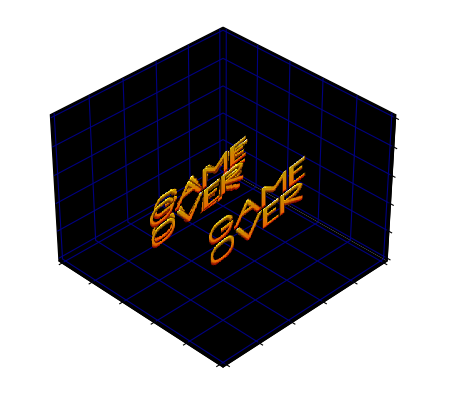

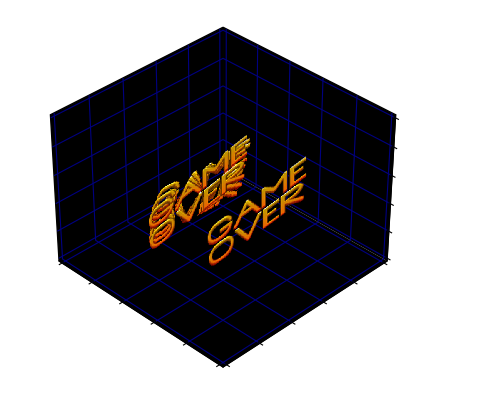

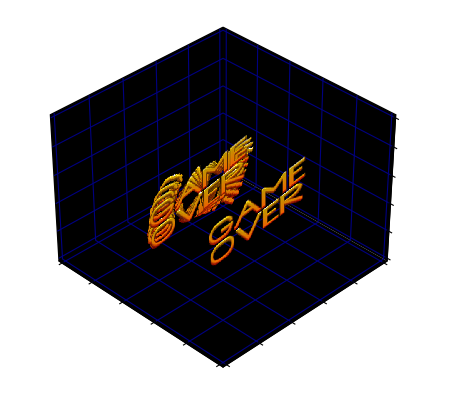

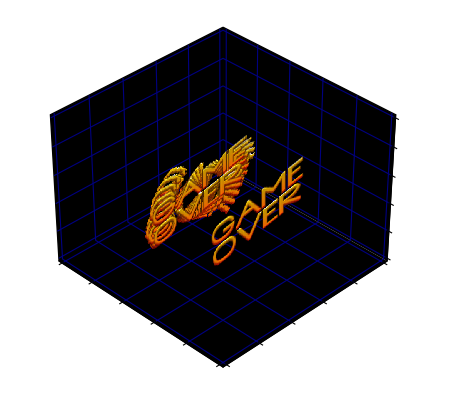

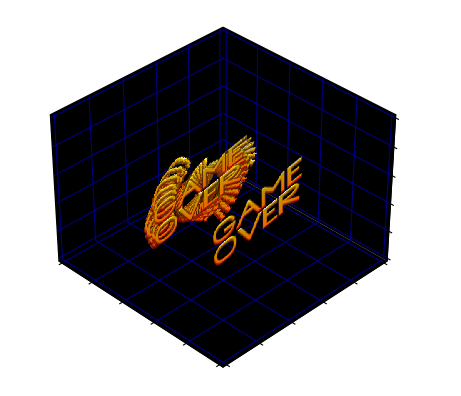

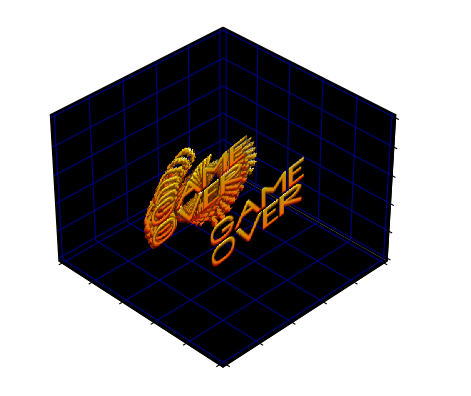

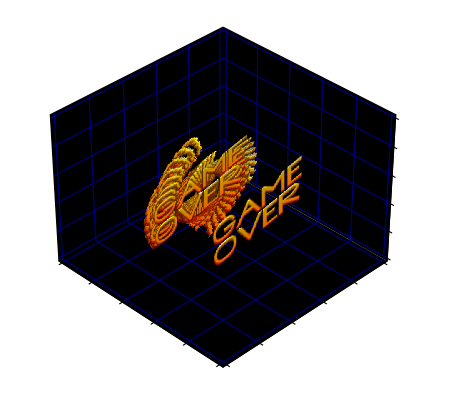

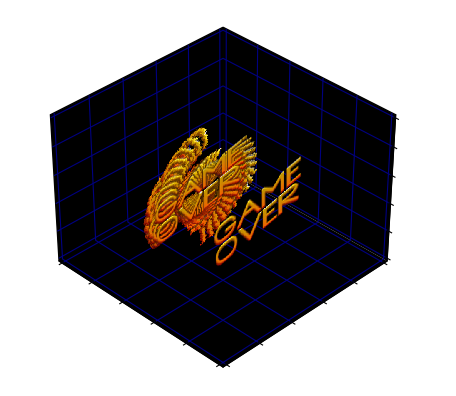

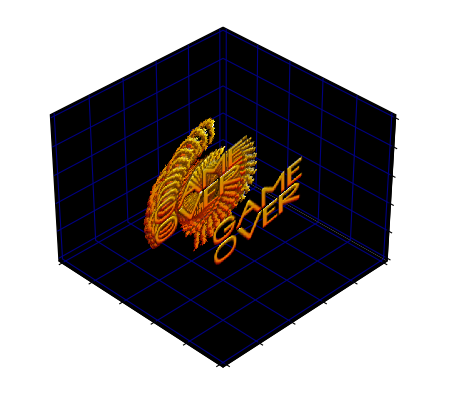

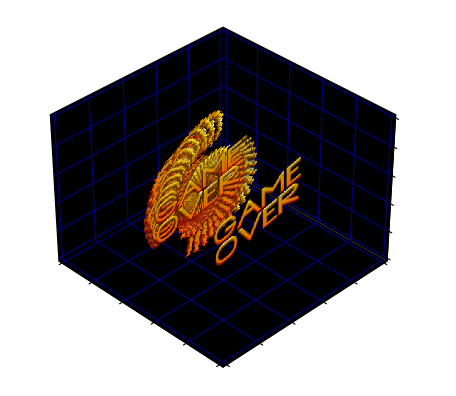

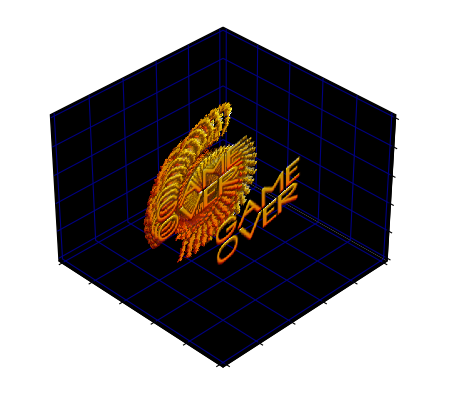

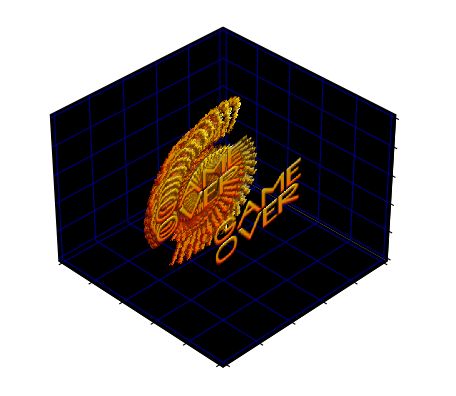

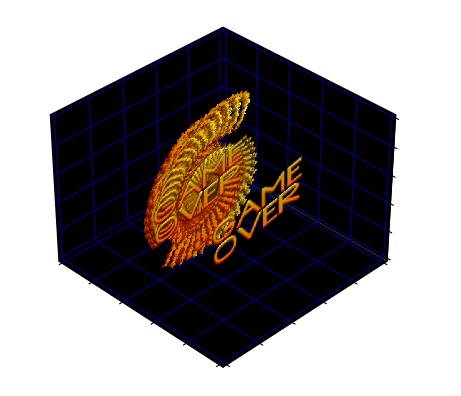

In [156]:
x = 148
y = 21
max_x = 310
max_y = 88
width = max_x - x
height = max_y - y
img = get_image_from_sprite_sheet(sprite_sheet, (x,y,max_x,max_y), size=(width,height))

CANVAS_WIDTH = 600
CANVAS_HEIGHT = 400
CANVAS_SIZE = (CANVAS_WIDTH, CANVAS_HEIGHT)

base_image = Image.new("RGBA", CANVAS_SIZE,"black")
base_image.paste(img, getCentre(CANVAS_SIZE, img.size),mask=img)
base_image = convert_black_to_transparent(base_image)

final_image = Image.new("RGBA", CANVAS_SIZE,"black")
rot = base_image
img = base_image
scale_factor = 1.03
xchoices = [-32, -16, 16, 32]
ychoices = [-8, -4, 4, 8]
for i in range(1,14):
    rot = scale_image(rot, scale_factor)
    rot = rot.rotate(-8)
    rw,rh = img.size
    rw += random.choice(xchoices)
    rh += random.choice(ychoices)
    img = img.resize((rw,rh))
    rot.paste(img, getCentre(rot.size, img.size),mask=img)
    final_image.paste(rot, getCentre(final_image.size, rot.size), mask=rot)
    plot_game_over(img,final_image,filename=f"layer{i}.png")


In [205]:
800/2.72

294.11764705882354

# Rough Work